In [2]:
import torch, torchvision, matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
import dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from sklearn.metrics import pairwise_distances



def softmax(a):
    max_vel = a.max()
    exp_a = (a - max_vel).exp()
    return exp_a.div(exp_a.sum())


def linear(x, weight, bias):
    return torch.matmul(weight, x) + bias


def loss(label, predictions):
    return -predictions[label].log()



def loss_softmax_backward(label, predictions):
    grad_inputs = predictions.clone()
    grad_inputs[label] = grad_inputs[label] - 1
    return grad_inputs



def linear_backward(x, weight, bias, gradOutput):
    gradBias = bias.clone().zero_()
    gradWeight = weight.clone().zero_()
    gradWeight = gradOutput * x.t()
    gradBias.copy_(gradOutput)

    return gradWeight, gradBias

This dataset has 1000 training images
Image 1 is a lighthouse
Image size is 3x48x48
Train-epoch 0. Iteration 00100 / 01000, Avg-Loss: 4.5349, Accuracy: 0.0300
Train-epoch 0. Iteration 00200 / 01000, Avg-Loss: 3.9036, Accuracy: 0.0300
Train-epoch 0. Iteration 00300 / 01000, Avg-Loss: 3.6511, Accuracy: 0.0267
Train-epoch 0. Iteration 00400 / 01000, Avg-Loss: 3.5110, Accuracy: 0.0375
Train-epoch 0. Iteration 00500 / 01000, Avg-Loss: 3.4428, Accuracy: 0.0400
Train-epoch 0. Iteration 00600 / 01000, Avg-Loss: 3.4047, Accuracy: 0.0367
Train-epoch 0. Iteration 00700 / 01000, Avg-Loss: 3.3576, Accuracy: 0.0400
Train-epoch 0. Iteration 00800 / 01000, Avg-Loss: 3.3282, Accuracy: 0.0375
Train-epoch 0. Iteration 00900 / 01000, Avg-Loss: 3.3390, Accuracy: 0.0389
Train-epoch 0. Iteration 01000 / 01000, Avg-Loss: 3.3248, Accuracy: 0.0380
Validation-epoch 0. Avg-Loss: 3.0753, Accuracy: 0.0500
Train-epoch 1. Iteration 00100 / 01000, Avg-Loss: 3.1286, Accuracy: 0.0200
Train-epoch 1. Iteration 00200 / 010

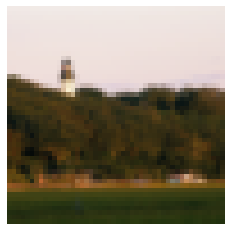

In [3]:
class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN, self).__init__()

        self.linear1 = nn.Linear(3 * 48 * 48, 512)
        self.linear2 = nn.Linear(512, 20)

    def forward(self, x):
        x = x.view(-1, 3 * 48 * 48)
        z = F.relu(self.linear1(x))
        return self.linear2(z)


alex_model = models.AlexNet()
alex_model.classifier[6] = nn.Linear(4096, 20)


transform = transforms.Compose([ transforms.ToTensor()])
image_index = 1

# 20 scene categories from the SUN397 dataset.
classes = ['airport_terminal', 'arch', 'bathroom', 'butte', 'castle',
           'classroom', 'dentists_office', 'hot_spring', 'jacuzzi',
           'laundromat', 'lecture_room', 'lighthouse', 'mountain',
           'sauna', 'server_room', 'shower', 'skyscraper', 'tower',
           'tree_house', 'volcano']


train_set = dataset.SUN20(split='train', transform=transform)
val_set = dataset.SUN20(split='validation', transform=transform)
print('This dataset has {0} training images'.format(len(train_set)))
img, label = train_set[image_index]  # Returns image and label.
print('Image {0} is a {1}'.format(image_index, classes[label]))
print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))
# All images have 3 channel x 48 rows x 48 columns.

plt.figure()
plt.imshow(img.transpose(0, 2).transpose(0, 1))
plt.grid(False)
plt.axis('off')
plt.show()
batchSize = 1

# Create the model.
model = TwoLayerNN()
loss_fn = nn.CrossEntropyLoss()

learningRate = 5e-2

# Optimizer.
optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9, weight_decay=1e-4)

#optimizer = optim.Adam(cnn_model.parameters(), lr = 3e-3)


def train_model(model, loss_fn, batchSize, trainset, valset, optimizer, num_epochs):
    # Shuffling is needed in case dataset is not shuffled by default.
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=batchSize,
                                               shuffle=True)
    # We don't need to bach the validation set but let's do it anyway.
    val_loader = torch.utils.data.DataLoader(dataset=valset,
                                             batch_size=batchSize,
                                             shuffle=False)  # No need.

    # Define number of epochs.
    N = num_epochs

    # log accuracies and losses.
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(0, N):
        correct = 0.0
        cum_loss = 0.0

        # Make a pass over the training data.
        model.train()
        for (i, (inputs, labels)) in enumerate(train_loader):
            #inputs = inputs.unsqueeze_(2)
            # Forward pass. (Prediction stage)
            scores = model(inputs)
            loss = loss_fn(scores, labels)

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            # Zero the gradients in the network.
            optimizer.zero_grad()

            # Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step) -- if done with torch.optim!
            optimizer.step()

            # Parameter updates (SGD step) -- if done manually!
            # for param in model.parameters():
            #   param.data.add_(-learningRate, param.grad)

            # Logging the current results on training.
            if (i + 1) % 100 == 0:
                print('Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Accuracy: %.4f' %
                      (epoch, i + 1, len(train_loader), cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / len(trainset))
        train_losses.append(cum_loss / (i + 1))

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):


            # Forward pass. (Prediction stage)
            #inputs = inputs.unsqueeze_(2)
            scores = model(inputs)
            cum_loss += loss_fn(scores, labels).item()

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(valset))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' %
              (epoch, cum_loss / (i + 1), correct / len(valset)))
    return train_losses, val_losses, train_accuracies, val_accuracies


train_losses, val_losses, train_accuracies,val_accuracies = train_model(model, loss_fn, batchSize, train_set, val_set, optimizer, 5)



weight = torch.zeros(20, 3* 48 * 48).normal_(0, 0.01)
bias = torch.zeros(20, 1).normal_(0, 0.01)

x = img.view(3*48*48, 1)
a = linear(x, weight, bias)
predictions = softmax(a)

for i, pred in enumerate(predictions.squeeze().tolist()):
    print("y_hat[%s] = %.2f" % (classes[i], pred))

learningRate = 1e-4
N = 5

train_accuracies = []
val_accuracies = []
train_loss = []
val_loss = []


for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    for (i, (img, label)) in enumerate(train_set):
        x = img.view(3*48*48, 1)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1

        gradOutput = loss_softmax_backward(label, predictions)
        gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)
        weight.add_(-learningRate, gradWeight)
        bias.add_(-learningRate, gradBias)

        if(i + 1) % 100 == 0:
            print("Train-epoch %d. Iteration %05d, Avg_loss: %.4f, Accuracy: %.4f" %
                  (epoch, i + 1, cum_loss/(i + 1), correct / (i + 1)))

    train_accuracies.append(correct / len(train_set))
    train_loss.append(cum_loss / len(train_set))


    correct = 0
    cum_loss = 0
    for(i, (img, label)) in enumerate(val_set):
        x = img.view(3*48*48, 1)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1

    val_accuracies.append(correct / len(val_set))
    val_loss.append(cum_loss / len(val_set))

    print("Validation epoch: %d, Avg_loss: %.4f, Accuracy: %.4f" %
          (epoch, cum_loss/len(val_set), correct/len(val_set)))


In [4]:
import numpy as np
img, label = val_set[1]
print(label)
scores = model(img)
max_scores, max_labels = scores.max(1)
max_scores = max_scores.data.numpy()

idx = np.argmax(max_scores)
print(label, classes[idx])

m = [1, 2, 3, 4]
m1 = [1, 2, 3, 4]
m2 = [3, 4, 6, 5]
m3 = [5, 6, 7, 8]

m_matrix = np.array([])
print("User: ")
for i in range(0, 4):
    img, label = val_set[m[i]]
    predictions = model(img)
    max_score, max_label = predictions.max(1)

    idx = np.argmax(max_scores)
    m_matrix = np.append(m_matrix, max_label.item())
    print(label, classes[idx])
m_matrix.shape = (2, 2)


print("_____ ")
m1_matrix = np.array([])
print("User1: ")
for i in range(0, 4):
    img, label = val_set[m1[i]]
    predictions = model(img)
    max_score, max_label = predictions.max(1)

    idx = np.argmax(max_scores)
    m1_matrix = np.append(m1_matrix, max_label.item())
    print(label, classes[idx])
m1_matrix.shape = (2, 2)

print("_____ ")
m2_matrix = np.array([])
print("User2: ")
for i in range(0, 4):
    img, label = val_set[m2[i]]
    predictions = model(img)
    max_score, max_label = predictions.max(1)

    idx = np.argmax(max_scores)
    m2_matrix = np.append(m2_matrix, max_label.item())
    print(label, classes[idx])

m2_matrix.shape = (2, 2)


print("_____ ")
m3_matrix = np.array([])
print("User3: ")
for i in range(0, 4):
    img, label = val_set[m[i]]
    predictions = model(img)
    max_score, max_label = predictions.max(1)

    idx = np.argmax(max_scores)
    m3_matrix = np.append(m3_matrix, max_label.item())
    print(label, classes[idx])

m3_matrix.shape = (2, 2)

dis1m = pairwise_distances(m_matrix, m1_matrix)
dis2m = pairwise_distances(m_matrix, m2_matrix)
dis3m = pairwise_distances(m_matrix, m3_matrix)

dis_mean1 = np.mean(dis1m)
dis_mean2 = np.mean(dis2m)
dis_mean3 = np.mean(dis3m)

s1 = 10-dis_mean1
s2 = 10-dis_mean2
s3 = 10-dis_mean3
print(s1, s2, s3)

print("similarity 1: ", s1)

print("similarity 2: ", s2)

print("similarity 3: ", s3)

prior_decision = []
prior_decision.append(s1)
prior_decision.append(s2)
prior_decision.append(s3)

prior_result = np.array(prior_decision)
print("Decision beliefs: User", np.argmax(prior_result)+1)

action_set = [10, 10, 10]

action_set = [2, 4, 5]
w1 = 0.2
w2 = 0.8
w3 = 2

matching_rate = 0

matching_rate = 0
final_result = np.array([])
result1 = int(input("input the user you want to choose: 1 = user1, 2 = user2, 3 = user 3, 4 = give up"))
matching_rate1 = int(result1)/2
if int(result1) == 0:
    matching_rate = 0

matching_formula1 = (w1 * action_set[0] + w2 * matching_rate) * w3 * 0.1
print("Matching score: %.4f"% matching_formula1)

final_result = np.append(final_result, matching_formula1)


result2 = int(input("input the user you want to choose: 1 = user1, 2 = user2, 3 =  give up"))
matching_rate2 = int(result2)/2
if int(result2) == 3:
    matching_rate2 = 0
matching_formula2 = (w1 * action_set[1] + w2 * matching_rate2)* w3 * 0.1
print("Matching score: %.4f"% matching_formula2)
final_result = np.append(final_result, matching_formula2)

result3 = int(input("input the user you want to choose: 1 = user1, 2 = give up"))
matching_rate3 = int(result2)/2
if int(result3) == 2:
    matching_rate3 = 0

matching_formula3 = (w1 * action_set[2] + w2 * matching_rate3)*w3 * 0.1
print("Matching score: %.4f"% matching_formula3)
final_result = np.append(final_result, matching_formula3)
print("New Decision: User: ", 3 - np.argmax(final_result))
new_decision = np.array([])
new_decision = np.append(new_decision, 3 - np.argmax(final_result))#save user
idx = np.argmax(final_result)
new_decision = np.append(new_decision, final_result[idx])#save score


10
10 airport_terminal
User: 
10 airport_terminal
11 airport_terminal
9 airport_terminal
15 airport_terminal
_____ 
User1: 
10 airport_terminal
11 airport_terminal
9 airport_terminal
15 airport_terminal
_____ 
User2: 
9 airport_terminal
15 airport_terminal
6 airport_terminal
15 airport_terminal
_____ 
User3: 
10 airport_terminal
11 airport_terminal
9 airport_terminal
15 airport_terminal
10.0 10.0 10.0
similarity 1:  10.0
similarity 2:  10.0
similarity 3:  10.0
Decision beliefs: User 1
Matching score: 0.0800
Matching score: 0.2400
Matching score: 0.2800
New Decision: User:  1


In [5]:
# model 2
u = [1, 2, 3, 4]
u1 = [1, 2, 3, 4]
u2 = [3, 4, 6, 5]
u3 = [5, 6, 7, 8]

u_matrix = np.array([])
print("User: ")
for i in range(0, 4):
    img, label = val_set[u[i]]
    #img = F.to_tensor(img)
    x = img.view(3 * 48 * 48, 1)
    a = linear(x, weight, bias)
    predictions = softmax(a)
    max_score, max_label = predictions.max(0)
    u_matrix = np.append(u_matrix, max_label.item())
    print(classes[label])

u_matrix.shape = (2, 2)

print("_____ ")
print("User1: ")

u1_matrix = np.array([])
for i in range(0, 4):
    img, label = val_set[u1[i]]
    #img = F.to_tensor(img)
    x = img.view(3 * 48 * 48, 1)
    a = linear(x, weight, bias)
    predictions = softmax(a)
    max_score, max_label = predictions.max(0)
    u1_matrix = np.append(u1_matrix, max_label.item())
    print(classes[label])

u1_matrix.shape = (2, 2)
print("_____ ")
print("User2: ")

u2_matrix = np.array([])
for i in range(0, 4):
    img, label = val_set[u2[i]]
    #img = F.to_tensor(img)
    x = img.view(3 * 48 * 48, 1)
    a = linear(x, weight, bias)
    predictions = softmax(a)
    max_score, max_label = predictions.max(0)
    u2_matrix = np.append(u2_matrix, max_label.item())
    print(classes[label])

u2_matrix.shape = (2, 2)
print("_____ ")

print("User3: ")
u3_matrix = np.array([])
for i in range(0, 4):
    img, label = val_set[u3[i]]
    #img = F.to_tensor(img)
    x = img.view(3 * 48 * 48, 1)
    a = linear(x, weight, bias)
    predictions = softmax(a)
    max_score, max_label = predictions.max(0)
    u3_matrix = np.append(u3_matrix, max_label.item())
    print(classes[label])

print("_____ ")
u3_matrix.shape = (2, 2)

dis1 = pairwise_distances(u_matrix, u1_matrix)
dis2 = pairwise_distances(u_matrix, u2_matrix)
dis3 = pairwise_distances(u_matrix, u3_matrix)

dis_mean1 = np.mean(dis1)
dis_mean2 = np.mean(dis2)
dis_mean3 = np.mean(dis3)

s1 = 10-dis_mean1
s2 = 10-dis_mean2
s3 = 10-dis_mean3


User: 
lecture_room
lighthouse
laundromat
shower
_____ 
User1: 
lecture_room
lighthouse
laundromat
shower
_____ 
User2: 
laundromat
shower
dentists_office
shower
_____ 
User3: 
shower
dentists_office
sauna
mountain
_____ 


In [6]:
## Match based on similarity
print("similarity 1: ", s1)

print("similarity 2: ", s2)

print("similarity 3: ", s3)

prior_decision = []
prior_decision.append(s1)
prior_decision.append(s2)
prior_decision.append(s3)

prior_result = np.array(prior_decision)
print("Decision beliefs: User", np.argmax(prior_result)+1)


action_set = [2, 4, 5]
w1 = 0.2
w2 = 0.8
w3 = 2

matching_rate = 0
final_result = np.array([])
result1 = input("input the user you want to choose: 1 = user1, 2 = user2, 3 = user 3, 4 = give up")
matching_rate1 = int(result1)/2
if int(result1) == 0:
    matching_rate = 0
matching_formula1 = (w1 * action_set[0] + w2 * matching_rate) * w3 * 0.2
print("Matching Score: %.4f"% (matching_formula1))

final_result = np.append(final_result, matching_formula1)


result2 = input("input the user you want to choose: 1 = user1, 2 = user2, 3 =  give up")
matching_rate2 = int(result2)/2
if int(result2) == 3:
    matching_rate2 = 0
matching_formula2 = (w1 * action_set[1] + w2 * matching_rate2 )* w3 * 0.2
print("Matching score: %.4f"% (matching_formula2))
final_result = np.append(final_result, matching_formula2)

result3 = input("input the user you want to choose: 1 = user1, 2 = give up")
matching_rate3 = int(result2)/2
if int(result3) == 2:
    matching_rate3 = 0

matching_formula3 = (w1 * action_set[2] + w2 * matching_rate3) * w3 * 0.2
print("Matching score: %.4f"% (matching_formula3))
final_result = np.append(final_result, matching_formula3)
print("New Decision: User: ", 3 - np.argmax(final_result))

#print(new_decision)
if(new_decision[1] < np.argmax(final_result)):
    print("Compared with previous recommendation, Final Decision: User: ", 3 - np.argmax(final_result))

else:
    print("Compared with previous recommendation, Final Decision: User: ", new_decision[0])

similarity 1:  6.0
similarity 2:  3.3654721887248975
similarity 3:  -1.1837867478493056
Decision beliefs: User 1
Matching Score: 0.1600
Matching score: 0.6400
Matching score: 0.4000
New Decision: User:  2
Compared with previous recommendation, Final Decision: User:  2
